### This notebook generates the moisture-CAPE joint distributions for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [15]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [16]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

In [17]:
# array of years
#years = np.arange( 1983, 2008 )
years = np.arange( 2000, 2001 )

# create list of file names
#file_years = file_concatenator_ERA(years)
file_years = file_concatenator_ERA5(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude").values
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude").values
print(np.nanmax(maxlat_array))
cape_array = nc_open_compile(file_years,"cape_mean").values  # SS_20250204 "cape" -> "cape_mean"

tropical_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) & (cape_array > 10))[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERA = negative_to_nan(lifetime_array)[tropical_indx] # SS_20250204 "tropical_rain_indx"->"tropical_indx"
rad_array = nc_open_compile(file_years,"rad")
rad_ERA = negative_to_nan(rad_array)[tropical_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERA = negative_to_nan(ctt_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERA = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERA = negative_to_nan(minctt_array)[tropical_indx]
cape_ERA = negative_to_nan(cape_array)[tropical_indx]

-18.0
20.0
(32869,)


In [18]:
#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERA = np.double((xr.open_dataset(file_years[0])).pressure_level.data)*100  # SS_20250204 "pressure"->"pressure_level"

# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERA = nc_open_compile( file_years, "temperature_mean", 'stack' )[tropical_indx] # SS_20250204 "temperature"->"temperature_mean" "tropical_rain_indx" -> "tropical_indx"
qvsat_ERA = eps * satVapP_liq(temp_ERA) / ( plev_ERA - satVapP_liq(temp_ERA) )

# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv_mean", 'stack' ) # SS_20250204 "qv"->"qv_mean"
qv_ERA = negative_to_nan(qv_array)[tropical_indx] # SS_20250204 "tropical_rain_indx" -> "tropical_indx"

# as in Singh et al. 2017 we calculate saturation deficit as the arithmetic mean
# between its values at 850, 700, and 550 hPa
i = np.argmin( np.abs(plev_ERA - 85000) )
sd850_ERA = (qvsat_ERA[:,i] - qv_ERA[:,i])*1000   # 1000 converts [kg kg-1] to [g kg-1]
i = np.argmin( np.abs(plev_ERA - 70000) )
sd700_ERA = (qvsat_ERA[:,i] - qv_ERA[:,i])*1000
i = np.argmin( np.abs(plev_ERA - 55000) )
sd550_ERA = (qvsat_ERA[:,i] - qv_ERA[:,i])*1000

sd_ERA = (sd850_ERA + sd700_ERA + sd550_ERA)/3
print( 'Min, Mean, and Max SD [g kg-1]: ' + str(np.nanmin(sd_ERA)) + ' ' + str(np.nanmedian(sd_ERA)) + ' ' + str(np.nanmax(sd_ERA)) )

Min, Mean, and Max SD [g kg-1]: -0.9855705447486827 1.8984516524943091 9.762481773405293


### Joint distribution of 1-SF_LT and CAPE filtering by morphology

In [19]:
# binning for saturation deficit
#xbins1 = np.linspace( 20, 100, 40 )
xbins1 = np.linspace( 0, 5, 30 )
ybins1 = np.logspace( 1.7, 3.5, 40 )

In [20]:
# Find the 25th percentile of lifetime to define 'short-lived' (3 hours)
i = np.where( lifetime_ERA <= np.percentile( lifetime_ERA, 25 ) )
sd_ERA_young = sd_ERA[i]
cape_ERA_young = cape_ERA[i]
i = np.where( (~np.isnan(sd_ERA_young)) & (~np.isnan(cape_ERA_young)) )
h1 = np.histogram2d( sd_ERA_young[i], cape_ERA_young[i], bins=[xbins1, ybins1] )

# Find the 75th percentile of lifetime to define 'long-lived' (11 hours)
i = np.where( lifetime_ERA >= np.percentile( lifetime_ERA, 75 ) )
sd_ERA_old = sd_ERA[i]
cape_ERA_old = cape_ERA[i]
i = np.where( (~np.isnan(sd_ERA_old)) & (~np.isnan(cape_ERA_old)) )
h2 = np.histogram2d( sd_ERA_old[i], cape_ERA_old[i], bins=[xbins1, ybins1] )

# Find the 25th percentile of extent to define 'small' (132 km)
i = np.where( maxrad_ERA <= np.percentile( maxrad_ERA, 25) )
sd_ERA_small = sd_ERA[i]
cape_ERA_small = cape_ERA[i]
i = np.where( (~np.isnan(sd_ERA_small)) & (~np.isnan(cape_ERA_small)) )
h3 = np.histogram2d( sd_ERA_small[i], cape_ERA_small[i], bins=[xbins1, ybins1] )
i = np.where( rad_ERA <= np.percentile( rad_ERA, 25) )
sd_ERA_small = sd_ERA[i]
cape_ERA_small = cape_ERA[i]
i = np.where( (~np.isnan(sd_ERA_small)) & (~np.isnan(cape_ERA_small)) )
h3a = np.histogram2d( sd_ERA_small[i], cape_ERA_small[i], bins=[xbins1, ybins1] )

# Find the 75th percentile of extent to define 'large' (400 km)
i = np.where( maxrad_ERA >= np.percentile( maxrad_ERA, 75) )
sd_ERA_big = sd_ERA[i]
cape_ERA_big = cape_ERA[i]
i = np.where( (~np.isnan(sd_ERA_big)) & (~np.isnan(cape_ERA_big)) )
h4 = np.histogram2d( sd_ERA_big[i], cape_ERA_big[i], bins=[xbins1, ybins1] )
i = np.where( rad_ERA > np.percentile( rad_ERA, 75) )
sd_ERA_big = sd_ERA[i]
cape_ERA_big = cape_ERA[i]
i = np.where( (~np.isnan(sd_ERA_big)) & (~np.isnan(cape_ERA_big)) )
h4a = np.histogram2d( sd_ERA_big[i], cape_ERA_big[i], bins=[xbins1, ybins1] )

# Find the 25th percentile of CTT to define 'deep' (188 K)
i = np.where( minctt_ERA <= np.percentile( minctt_ERA, 25 ) )
sd_ERA_deep = sd_ERA[i]
cape_ERA_deep = cape_ERA[i]
i = np.where( (~np.isnan(sd_ERA_deep)) & (~np.isnan(cape_ERA_deep)) )
h5 = np.histogram2d( sd_ERA_deep[i], cape_ERA_deep[i], bins=[xbins1, ybins1] )

# Find the 75th percentile of CTT to define 'shallow' (201 K)
i = np.where(minctt_ERA >= np.percentile( minctt_ERA, 75 ))
sd_ERA_shallow = sd_ERA[i]
cape_ERA_shallow = cape_ERA[i]
i = np.where( (~np.isnan(sd_ERA_shallow)) & (~np.isnan(cape_ERA_shallow)) )
h6 = np.histogram2d( sd_ERA_shallow[i], cape_ERA_shallow[i], bins=[xbins1, ybins1] )

In [21]:
font_size = 18
def scatter_hist(x, y, xbins, ybins, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    h = ax.hist2d( x, y, bins=(xbins, ybins), cmap=cm.Blues )
    wgts = np.ones_like(x)/float(len(x))*100
    ax_histx.hist(x, bins=xbins, edgecolor='k', weights=wgts )
    ax_histx.tick_params(axis='both', which='major', labelsize=font_size-5)
    wgts = np.ones_like(y)/float(len(y))*100
    ax_histy.hist(y, bins=ybins, edgecolor='k', weights=wgts, orientation='horizontal')
    ax_histy.tick_params(axis='both', which='major', labelsize=font_size-5)
    #ax_histy.set_yscale('log')
    return h

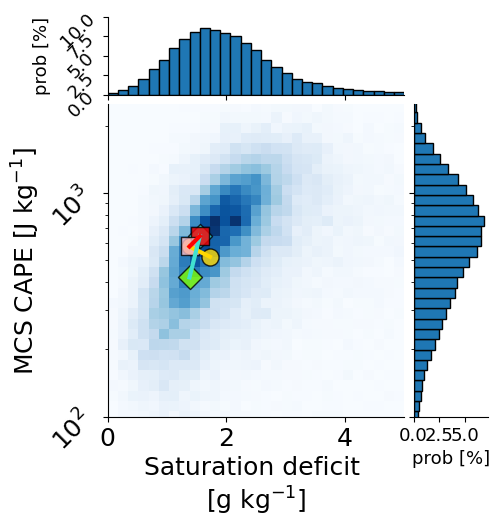

In [22]:
fig = plt.figure( figsize=(4.75,5) )
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
gs = fig.add_gridspec( 2, 2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9,
                     wspace=0.05, hspace=0.05 )
ax = fig.add_subplot( gs[1,0] )
ax_histx = fig.add_subplot( gs[0,0], sharex=ax )
ax_histy = fig.add_subplot( gs[1,1], sharey=ax )

## main panel a
i = np.where( (~np.isnan(sd_ERA)) & (~np.isnan(cape_ERA)) & (cape_ERA > 10) )
scatter_hist( sd_ERA[i], cape_ERA[i], xbins1, ybins1, ax, ax_histx, ax_histy )
#ax.set_xticks( [20, 40, 60, 80] )
ax_histx.set_ylabel( 'prob [%]', fontsize=font_size-5 )
ax_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax_histy.set_xlabel( 'prob [%]', fontsize=font_size-5 )
ax_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax.set_ylabel( r'MCS CAPE [J kg$^{-1}$]' )
ax.set_xlabel( r'Saturation deficit '
              '\n'
              '[g kg$^{-1}$]' )
ax.set_yscale('log')
ax.set_ylim([100,2500])
##

## Where is the center of mass of the joint distribution for young/old/big/small systems? 
# (The cells below must be run for this.)
h_csfpmax = [ h3, h4, h5, h6, h1, h2 ]
farbe = [ 'gold', 'darkorange', 'turquoise', 'lawngreen', 'red', 'pink' ]
forme = [ 'o', 'o', 'D', 'D', 's', 's' ]
##grose = [ 200, 200, 200, 200, 200, 200 ]
for i, histo, f, s in zip( np.arange(8), h_csfpmax, farbe, forme ):
    l, m = unravel_index( histo[0].argmax(), histo[0].shape )
    ax.scatter( xbins1[l], ybins1[m], marker=s, color=f, s=150, zorder=5, edgecolor='k', alpha=0.8 )
    if i%2 == 0:
        ll, mm = unravel_index( h_csfpmax[i+1][0].argmax(), h_csfpmax[i+1][0].shape )
        ax.plot( [xbins1[l], xbins1[ll]], [ybins1[m], ybins1[mm]], lw=3, color=f, zorder=10 )

for a in ax, ax_histx, ax_histy:
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    for t in a.get_yticklabels():
        t.set_rotation(45)

plt.tight_layout()
fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/sd-cape-joint-ERA.pdf', bbox_inches='tight' )
plt.show()